In [1]:
import matplotlib.pyplot as plt
import collections
from math import *
import argparse
import numpy as np
import os
import torch.nn.functional as F
import torch
from torch_geometric.data import Data
import torch_geometric.transforms as T
import torch_geometric.utils as utils
from torch_sparse import remove_diag
import random
# use type-1 font
# plt.switch_backend('agg')
# plt.rcParams['pdf.use14corefonts'] = True
# font = {'size': 18, 'family': 'Helvetica'}
# plt.rc('font', **font)
def set_rand_seed(rand_seed):
    rand_seed = rand_seed if rand_seed >= 0 else torch.initial_seed() % 4294967295  # 2^32-1
    random.seed(rand_seed)
    torch.manual_seed(rand_seed)
    torch.cuda.manual_seed_all(rand_seed)
    np.random.seed(rand_seed)

set_rand_seed(0)

In [2]:
# load from 'vanilla' attack where we will just do nothing
graph_path = os.path.join("atkg","grb-cora")+"_vanilla.pt"
new_data = torch.load(graph_path).cpu()
target_idx = torch.nonzero(new_data.test_mask,as_tuple=True)[0]

In [3]:
# quick preprocessing
x = new_data.x
y = new_data.y
orig_num_nodes = new_data.y.size(0)
neg_idx = torch.where(torch.logical_or(new_data.edge_index[0]>=orig_num_nodes,new_data.edge_index[1]>=orig_num_nodes))
pos_mask = torch.ones(new_data.edge_index.size(1)).bool()
pos_mask[neg_idx] = 0
neg_mask = torch.zeros(new_data.edge_index.size(1)).bool()
neg_mask[neg_idx] = 1

pos_edge_index = new_data.edge_index[:,pos_mask]    # original edges
neg_edge_index = new_data.edge_index[:,neg_mask]    # injected edges
edge_index = new_data.edge_index    # all edges
adj = T.ToSparseTensor()(new_data).adj_t

In [4]:
def edge_sim_analysis(edge_index, features):
    sims = []
    for (u,v) in zip(edge_index[0],edge_index[1]):
        sims.append(F.cosine_similarity(features[u].unsqueeze(0),features[v].unsqueeze(0)).item())
    sims = np.array(sims)
    print(f"mean: {sims.mean()}, <0.1: {sum(sims<0.1)}/{sims.shape[0]}")
    return sims
def inj_edge_sim_analysis(new_data):
    neg_idx = torch.where(torch.logical_or(new_data.edge_index[0]>=orig_num_nodes,new_data.edge_index[1]>=orig_num_nodes))
    pos_mask = torch.ones(new_data.edge_index.size(1)).bool()
    pos_mask[neg_idx] = 0
    neg_mask = torch.zeros(new_data.edge_index.size(1)).bool()
    neg_mask[neg_idx] = 1

    pos_edge_index = new_data.edge_index[:,pos_mask]    # original edges
    neg_edge_index = new_data.edge_index[:,neg_mask]    # injected edges
    sims = []
    for (u,v) in zip(neg_edge_index[0],neg_edge_index[1]):
        sims.append(F.cosine_similarity(new_data.x[u].unsqueeze(0),new_data.x[v].unsqueeze(0)))
    sims = np.array(sims)
    print(f"mean: {sims.mean()}, <0.1: {sum(sims<0.1)}/{sims.shape[0]}")
    return sims

edge_sims = edge_sim_analysis(edge_index, x)

mean: 0.4839295204853669, <0.1: 94/10296


In [5]:
# analyze 1-hop neighbor cosine similarity
from torch_sparse import SparseTensor, matmul, fill_diag, sum as sparsesum, mul
def gcn_norm(adj_t, order=-0.5, add_self_loops=True):
    if not adj_t.has_value():
        adj_t = adj_t.fill_value(1., dtype=None)
    if add_self_loops:
        adj_t = fill_diag(adj_t, 1.0)
    deg = sparsesum(adj_t, dim=1)
    deg_inv_sqrt = deg.pow_(order)
    deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0.)
    adj_t = mul(adj_t, deg_inv_sqrt.view(-1, 1))
    adj_t = mul(adj_t, deg_inv_sqrt.view(1, -1))
    return adj_t

adj = gcn_norm(adj,add_self_loops=False)
x_neg = adj @ x
node_sims = np.array([F.cosine_similarity(xn.unsqueeze(0),xx.unsqueeze(0)).item() for (xn,xx) in zip(x_neg,x)])    

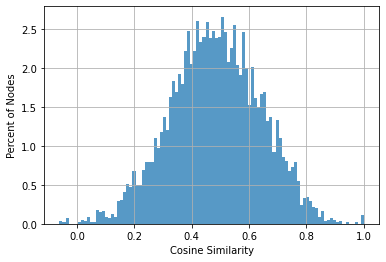

In [6]:
plt.hist(edge_sims, 100, density=True, alpha=0.75)
plt.grid(True)
# plt.title("GRB-CORA Edge-centric Cosine Similarity")
plt.xlabel("Cosine Similarity")
plt.ylabel("Percent of Nodes")
# plt.savefig("pics/grb_cora_edge_sims.png")
# plt.savefig("pics/grb_cora_edge_sims.pdf")
plt.show()
plt.close()

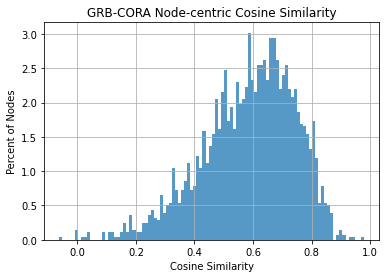

In [7]:
plt.hist(node_sims, 100, density=True, alpha=0.75)
plt.grid(True)
plt.title("GRB-CORA Node-centric Cosine Similarity")
plt.xlabel("Cosine Similarity")
plt.ylabel("Percent of Nodes")
# plt.savefig("pics/grb_cora_node_sims.png")
# plt.savefig("pics/grb_cora_node_sims.pdf")
plt.show()
plt.close()

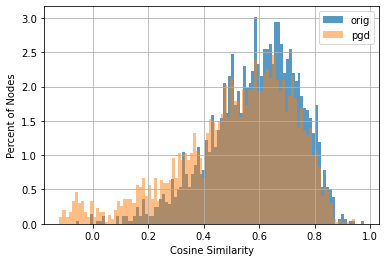

In [8]:
graph_path = os.path.join("atkg","grb-cora")+"_pgd.pt"
new_data = torch.load(graph_path).cpu()
adj = T.ToSparseTensor()(new_data).adj_t
x = new_data.x
adj = gcn_norm(adj,add_self_loops=False)
x_neg = adj @ x
node_sims_pgd = np.array([F.cosine_similarity(xn.unsqueeze(0),xx.unsqueeze(0)).item() for (xn,xx) in zip(x_neg,x)])    

plt.hist(node_sims, 100, density=True, alpha=0.75, label='orig')
plt.hist(node_sims_pgd, 100, density=True, alpha=0.5, label='pgd')
plt.grid(True)
# plt.title("GRB-CORA Node-centric Cosine Similarity")
plt.legend()
plt.xlabel("Cosine Similarity")
plt.ylabel("Percent of Nodes")
# plt.savefig("pics/grb_cora_node_sims_atk.png")
# plt.savefig("pics/grb_cora_node_sims_atk.pdf")

plt.show()
plt.close()